* Suppose we are given the set of unit vectors $u_k$'s (in practice no), at step $k$, we need to compute $g^{(k)}_j$ for each word $j$, and pick the largest one as anchor word. 

* We computed $(\hat{g}_j, \hat{v}(\hat{g}))$ from Jack-knife methods. Also have access to true $\hat{v}(\hat{g})$ by cheating (sample more experiments).
    * From previous experiment, already know our $\hat{v}(\hat{g}))$ overestimates more and more as step $k$ proceeds.

* Then apply shrinkage methods to $\hat{g}_j$'s and see if we can uncover anchor words. Better still, among anchor words, we hope to find the one with more word frequency (called weight below)

In [1]:
import os
import sys
import pickle
import argparse
from scipy import sparse, io 
import numpy as np
import rpy2.robjects as robjects
import magic
import scprep
from sklearn.decomposition import NMF, non_negative_factorization, PCA
from sklearn.decomposition._nmf import _beta_divergence
import seaborn as sns
import pandas as pd
from scipy.sparse import csr_matrix, csc_matrix 


script_dir = "../"
sys.path.append(os.path.abspath(script_dir))
from file2 import *
from factorize import *
from smallsim_functions import simulate_multinomial_counts
from misc import *
from findK_correction_constd_jk2 import *

import pdb

np.random.seed(123)

In [2]:
Yfile = "../../ebpmf_data_analysis/output/fastTopics_fit/sla_small.txt"
datafile="../../ebpmf_data_analysis/output/fastTopics_fit/sla_small_fitted.Rds"
vocabfile="../../ebpmf_data_analysis/output/fastTopics_fit/sla_small_vocab.txt"
titlefile="../../ebpmf_data_analysis/data/SLA/title.sla.txt"

## load data and fitted L, F, s
Y = io.mmread(Yfile)
vocab = np.loadtxt(vocabfile, dtype = str)
readRDS = robjects.r['readRDS']
data = readRDS(datafile)
w_idx = np.asarray(data.rx2('word_idx')).astype(int)
fitted = data.rx2('fit_sub')
F = np.asarray(fitted.rx2('F'))
L = np.asarray(fitted.rx2('L'))
s = np.asarray(fitted.rx2('s'))
p, k = F.shape
n = L.shape[0]

C = L @ F.T
C = C.T @ C / n
Cbar = C / C.sum(axis = 1)[:, None]
w_true = C.sum(axis = 1)


In [3]:
def get_truth(Cbar, K):
    p = Cbar.shape[0]
    U = np.zeros((p, K))
    R = Cbar.T
    S = np.zeros(K)
    gs = np.zeros((p, K))
    g = (R**2).sum(axis = 0) 
    for k in range(K):
        gs[:, k] = g
        maxSquaredSum = np.max(g)
        maxCol = np.argmax(g)
        S[k] = maxCol
        u = R[:, maxCol].copy()
        u = u / np.sqrt(maxSquaredSum)
        U[:, k] = u
        R = R -  u[:, None] @ (u[:,None].T @ R)
        dg = (Cbar @ u)**2
        g -= dg        

    return S, U, gs

def show_shrinkage(k_, i_, est, se):
    p = se.shape[0]
    a = a_words[k_]
    ind = np.zeros(p, dtype=bool)
    ind[a] = True
    
    se_ = se[:, k_, i_]
    est_ = est[:, k_, i_]
    est_shrunk = shrink(est_, np.square(se_))
    
    x = np.log10(w_true)
    y = est_
    
    plt.scatter(x[ind], y[ind], c = "red")
    plt.scatter(x[~ind], y[~ind], c = "blue", alpha = 0.1)
    plt.xlim((0.9 * x.min(), 1.1 * x.max()))
    plt.ylim((0.9 * y.min(), 1.1 * y.max()))
    plt.xlabel("weight")
    plt.ylabel("ghat")
    plt.show()

    y = est_shrunk
    plt.scatter(x[ind], y[ind], c = "red")
    plt.scatter(x[~ind], y[~ind], c = "blue", alpha = 0.1)
    plt.xlim((0.9 * x.min(), 1.1 * x.max()))
    plt.ylim((0.9 * y.min(), 1.1 * y.max()))
    plt.xlabel("weight")
    plt.ylabel("ghat (shrunk w/ ested se)")
    plt.show()
    
    se_true = np.sqrt(((est[:, k_, :] - est[:, k_, :].mean(axis = 1)[:, None])**2).mean(axis = 1))
    est_shrunk = shrink(est_, np.square(se_true))
    y = est_shrunk
    plt.scatter(x[ind], y[ind], c = "red")
    plt.scatter(x[~ind], y[~ind], c = "blue", alpha = 0.1)
    plt.xlim((0.9 * x.min(), 1.1 * x.max()))
    plt.ylim((0.9 * y.min(), 1.1 * y.max()))
    plt.xlabel("weight")
    plt.ylabel("ghat (shrunk w/ true se)")
    plt.show()
    
    x = se_true
    y = se_
    fig, ax = plt.subplots(1)
    ax.scatter(x[ind], y[ind], c = "red")
    ax.scatter(x[~ind], y[~ind], c = "blue", alpha = 0.1)
    plt.xlim((0.9 * x.min(), 1.1 * x.max()))
    plt.ylim((0.9 * y.min(), 1.1 * y.max()))
    plt.xlabel("se true")
    plt.ylabel("se est")
    
    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    plt.show()

In [4]:
S, U, gs = get_truth(Cbar, k)

## get all true anchor words
a_words = {}
for i in range(k):
    s = S[i].astype(int)
    k_ = np.argmax(F[s, :])
    a_words[i] = np.where(find_anchor_word_k2(F, k_, 10) == True)[0]

## $n = 3207$

step 1


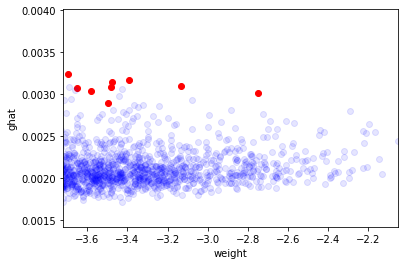

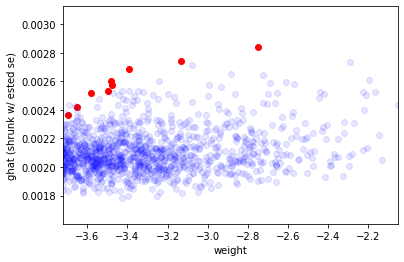

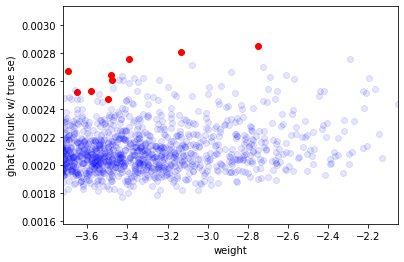

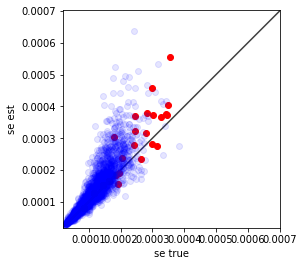

step 2


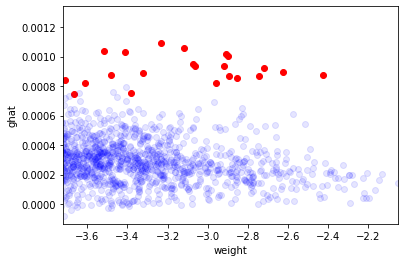

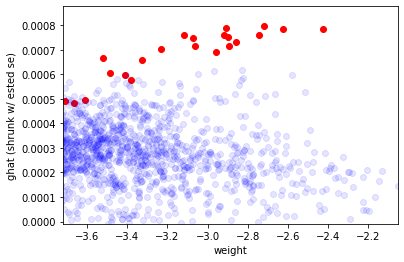

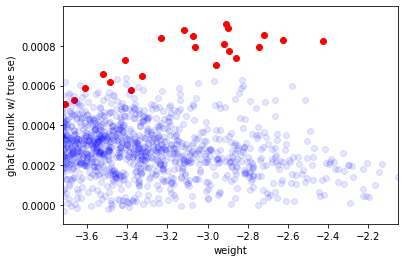

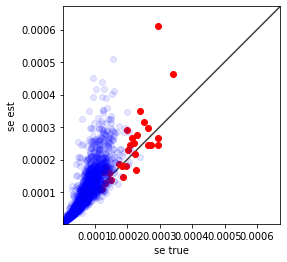

step 3


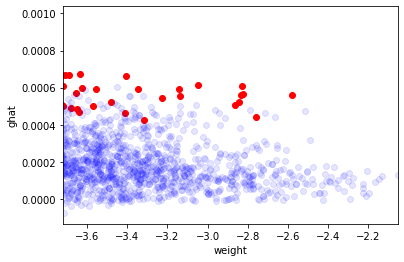

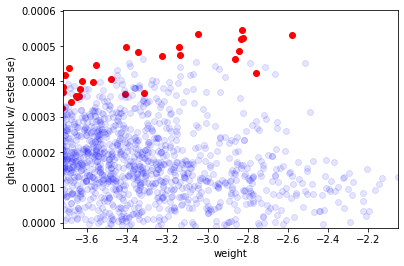

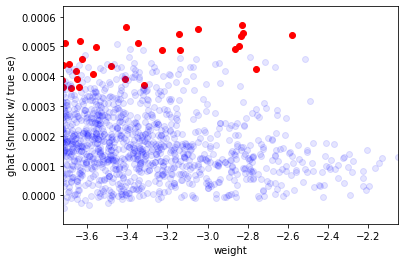

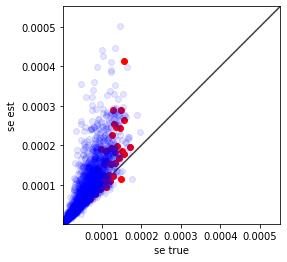

step 4


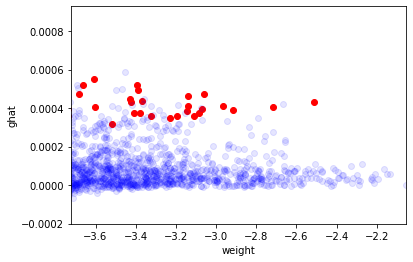

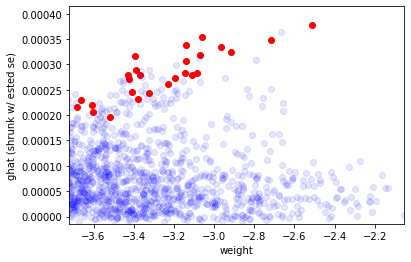

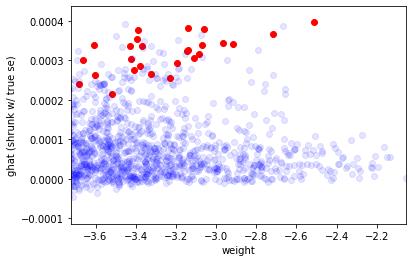

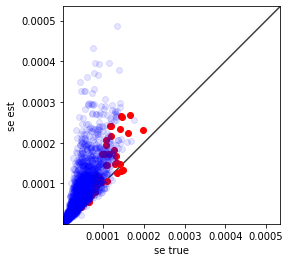

step 5


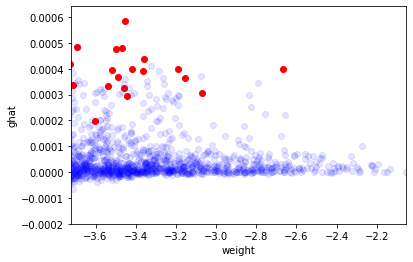

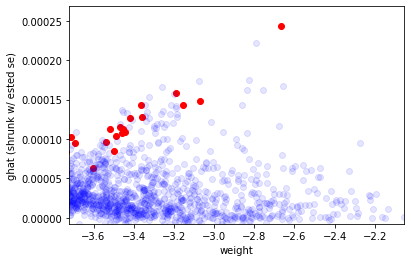

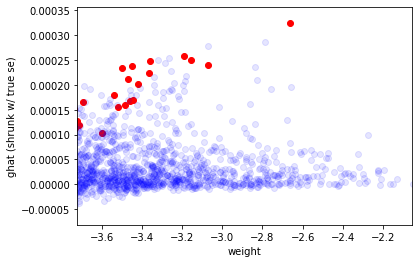

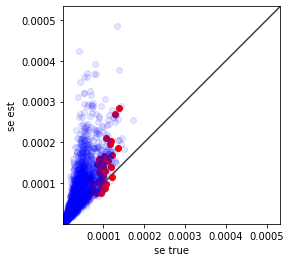

step 6


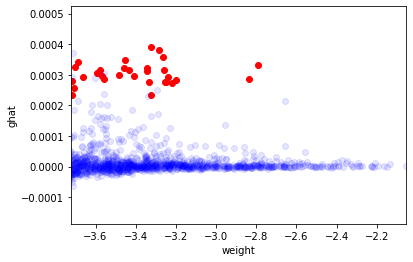

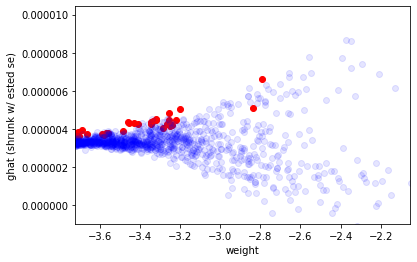

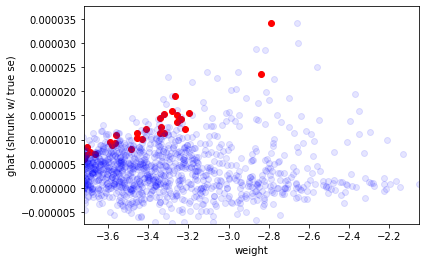

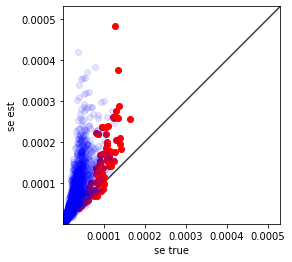

In [5]:
outputfile="findK-exper-constd-jk2.pkl"
with open(outputfile, "rb") as f:
    tmp = pickle.load(f)

est = tmp['est']
se = tmp['se']

i_ = 12
for k_ in range(k):
    print(f"step {k_ + 1}")
    show_shrinkage(k_, i_, est.copy(), se.copy())

works fine, except for step 6: shrinkage based on overestimated SE makes it worse

## $n = 6414$

step 1


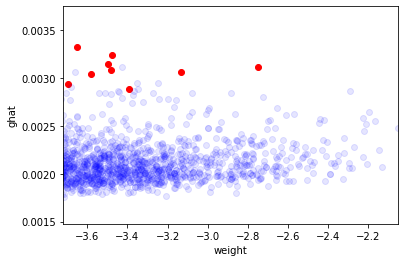

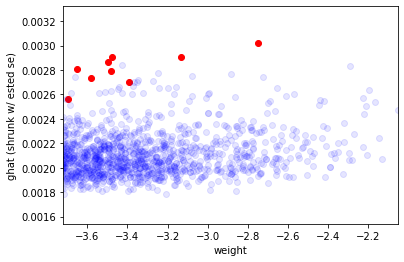

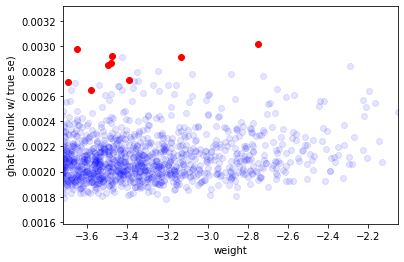

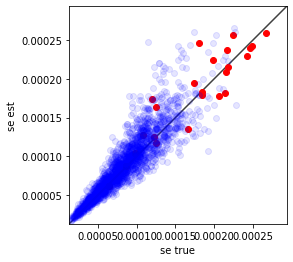

step 2


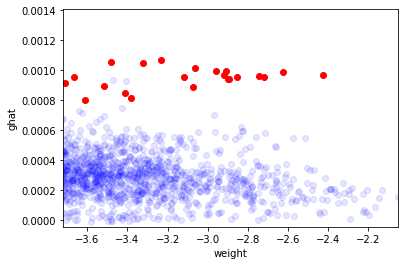

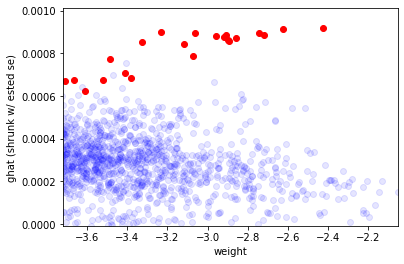

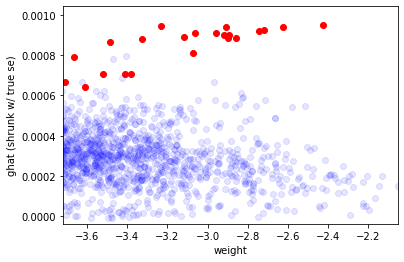

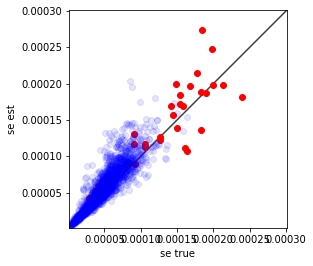

step 3


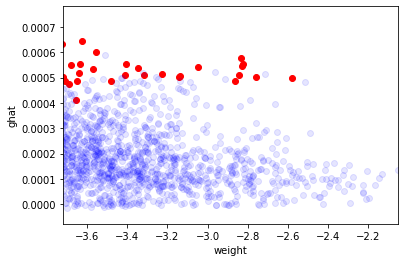

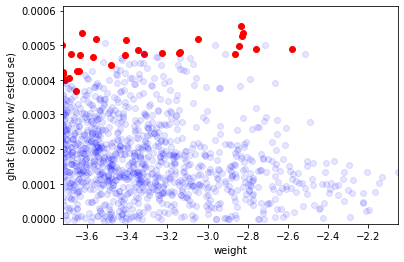

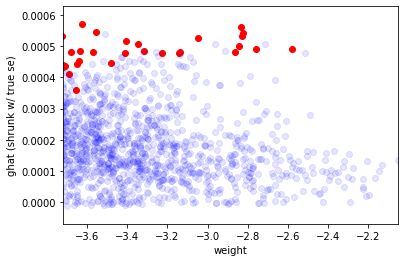

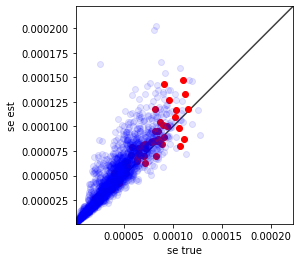

step 4


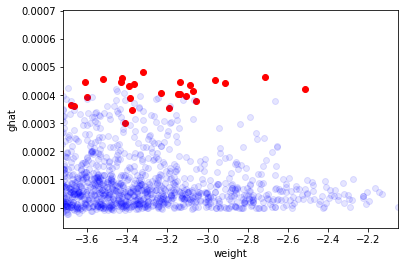

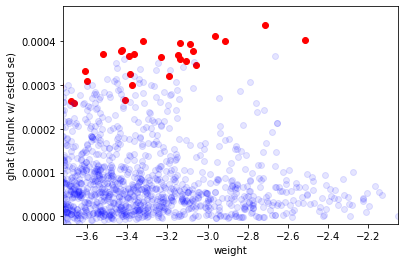

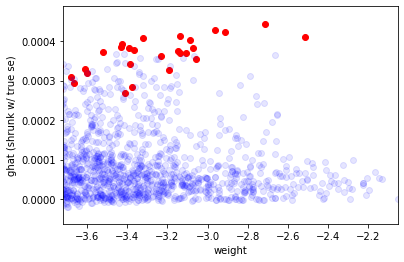

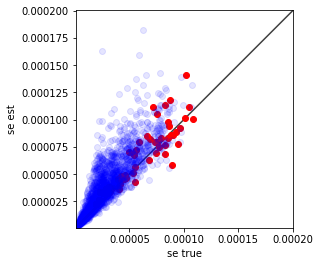

step 5


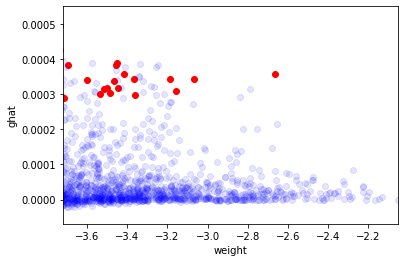

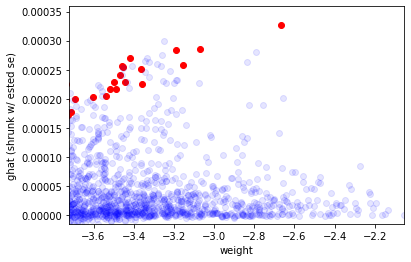

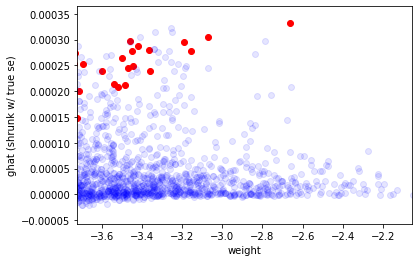

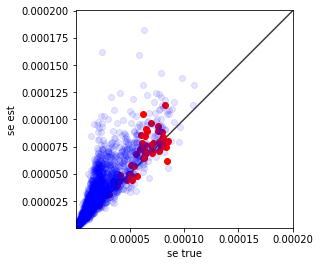

step 6


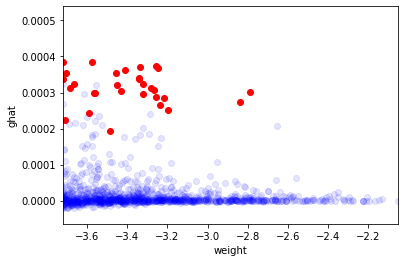

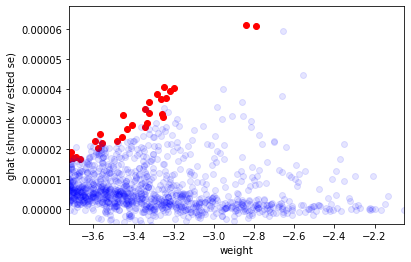

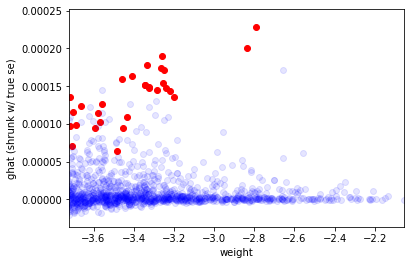

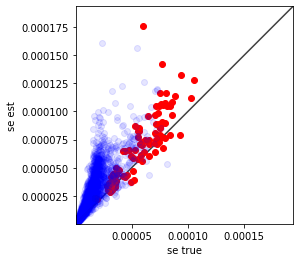

In [6]:
outputfile="findK-exper-constd-jk2-bigger.pkl"
with open(outputfile, "rb") as f:
    tmp = pickle.load(f)

est = tmp['est']
se = tmp['se']

i_ = 12
for k_ in range(k):
    print(f"step {k_ + 1}")
    show_shrinkage(k_, i_, est.copy(), se.copy())